# Bike Sharing in Washington D.C.

Statistical Programming - Python | MBD OCT 2018  
*IE School of Human Sciences and Technology*  

***

## Introduction

### Objectives

This case study of the Washington D.C Bike Sharing System aims to predict the total number of users on an hourly basis. The dataset is [available on Kaggle](https://www.kaggle.com/marklvl/bike-sharing-dataset/home). It contains usage information of years 2011 and 2012.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington).

### Libraries

This project uses a set of libraries for data manipulation, ploting and modelling.

In [5]:
# Loading Libraries
import pandas as pd #Data Manipulation - version 0.23.4
pd.set_option('display.max_columns', 500)
import numpy as np #Data Manipulation - version 1.15.4
import datetime

import matplotlib.pyplot as plt #Plotting - version 3.0.2
import matplotlib.ticker as ticker #Plotting - version 3.0.2
import seaborn as sns #Plotting - version 0.9.0
sns.set(style='white')

from sklearn import preprocessing #Preprocessing - version 0.20.1
from sklearn.preprocessing import MinMaxScaler #Preprocessing - version 0.20.1

from scipy.stats import skew, boxcox_normmax #Preprocessing - version 1.1.0
from scipy.special import boxcox1p #Preprocessing - version 1.1.0

from sklearn.model_selection import train_test_split #Train/Test Split - version 0.20.1
from sklearn.model_selection import TimeSeriesSplit #Timeseries CV - version 0.20.1
from sklearn import datasets, linear_model #Model - version 0.20.1
from sklearn.linear_model import LinearRegression #Model - version 0.20.1


from sklearn.metrics import mean_squared_error, r2_score #Metrics - version 0.20.1
from sklearn.metrics import accuracy_score #Metrics - version 0.20.1
from sklearn.model_selection import cross_val_score, cross_val_predict # CV - version 0.20.1
from sklearn.feature_selection import RFE #Feature Selection - version 0.20.1

### Data Loading

The dataset is stored in the [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington) consisting in two CSV file: `day.csv` and `hour.csv`. The files are loaded directly from the repository.

In [2]:
hours_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/hour.csv")
hours_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
days_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/day.csv")
days_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [4]:
# Shape of the data frame
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('hour.csv:', hours_df.shape[0],'rows |', hours_df.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('day.csv:', days_df.shape[0],'rows |', days_df.shape[1], 'columns'))

hour.csv:  17379 rows |  17 columns
day.csv:     731 rows |  16 columns


In [5]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                         'Date': df.dtypes == 'datetime64[ns]',
                        })
    return desc

In [10]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False
temp,float64,0,True,False,False,False


In [11]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
hr,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False


The dataset `day.csv` consists in 731 rows and 16 columns. The dataset `hour.csv` consists in 17,379 rows and 17 columns. Both datasets have the same columns, with an additional column for hours in `hour.csv`.

Each row provides information for each day or each hour. None of the attributes contains any NA. Four (4) of these attributes contain decimal numbers, nine (9) contain integers, three (3) contain booleans, and one (1) contains date values stored as string.

For better readability, the columns of both data frames are renamed and data types are adjusted.

In [12]:
# HOURS DATASET
# Renaming columns names to more readable names
hours_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'hr':'hour',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
                inplace=True)

# Date time conversion
hours_df.date = pd.to_datetime(hours_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year','hour']:
    hours_df[column] = hours_df[column].astype('category')
    
# DAYS DATASET
# Renaming columns names to more readable names
days_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
               inplace=True)

# Date time conversion
days_df.date = pd.to_datetime(days_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year']:
    days_df[column] = days_df[column].astype('category')

In [9]:
hours_df.head()

,id,date,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [14]:
hours_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
# Lists values of categorical variables
categories = {'season': hours_df['season'].unique().tolist(),
              'year':hours_df['year'].unique().tolist(),
              'month':hours_df['month'].unique().tolist(),
              'hour':hours_df['hour'].unique().tolist(),
              'holiday':hours_df['holiday'].unique().tolist(),
              'weekday':hours_df['weekday'].unique().tolist(),
              'workingday':hours_df['workingday'].unique().tolist(),
              'weather_condition':hours_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

hour:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[1, 2, 3, 4]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [16]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [17]:
days_df.head()

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [18]:
days_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [15]:
# Lists values of categorical variables
categories = {'season': days_df['season'].unique().tolist(),
              'year':days_df['year'].unique().tolist(),
              'month':days_df['month'].unique().tolist(),
              'holiday':days_df['holiday'].unique().tolist(),
              'weekday':days_df['weekday'].unique().tolist(),
              'workingday':days_df['workingday'].unique().tolist(),
              'weather_condition':days_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[2, 1, 3]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [20]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False


The datasets contain 17 variables with no NAs:

- `id`: numerical, integer values.  
  *Record index. This variable won't be considered in the study.*
  
  
- `date`: numerical, date values.  
  *Date.*


- `season`: encoded categorical, integer between 1 and 4.  
  *Season: 1=Spring, 2=Summer, 3=Fall, 4=Winter.*


- `year`: encoded categorical, integer between 0 and 1.  
  *Year: 0=2011, 1=2012.*
  
  
- `month`: encoded categorical, integer between 1 and 12.  
  *Month.*
  
  
- `hour`: encoded categorical, integer between 1 and 23.  
  *Hour.*
  
  
- `holiday`: encoded categorical, boolean.  
  *Flag indicating if the day is a holiday.*


- `weekday`: encoded categorical, integer between 0 and 6.  
  *Day of the week (0=Sunday, ... 6=Saturday).*


- `workingday`: encoded categorical, boolean.  
  *Flag indicating if the day is a working day.*
  
  
- `weather_condition`: encoded categorical, integer between 1 and 4.  
  *Weather condition (1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain).*


- `actual_temp`: numerical, decimal values between 0 and 1.  
  *Normalized temperature in Celsius (min = -16, max = +50).*


- `feeling_temp`: numerical, decimal values between 0 and 1.  
  *Normalized feeling temperature in Celsius (min = -8, max = +39).*


- `humidity`: numerical, decimal values between 0 and 1.  
  *Normalized humidity.*


- `windspeed`: numerical, decimal values between 0 and 1.  
  *Normalized wind speed.*


- `casual`: numerical, integer.  
  *Count of casual users.*


- `registered`: numerical, integer.  
  *Count of registered users. This variable won't be considered in the study.*


- `total_bikes`: numerical, integer.  
  *Count of total rental bikes (casual+registered). This is the __target variable__ of the study, the one to be modelled.*

In [17]:
# Remove variable id
hours_df= hours_df.drop(['id'], axis=1)

### Exploratory Data Analysis

#### Bike sharing utilization over the two years

The objective of this study is to build a model to predict the value of the variable `total_bikes`, based on the other variables available.

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


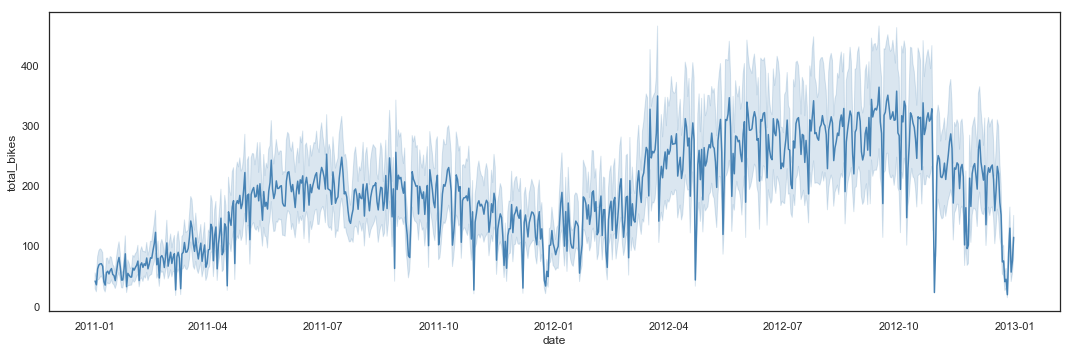

In [18]:
# Total_bikes evolution per day
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.date,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Based on the two years dataset, it seems that the utilization of the bike sharing service has increased over the period. The number of bikes rented per day also seems to vary depending on the season, with Spring and Summer months being showing a higher utilization of the service.

#### Bike sharing utilization by Month

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


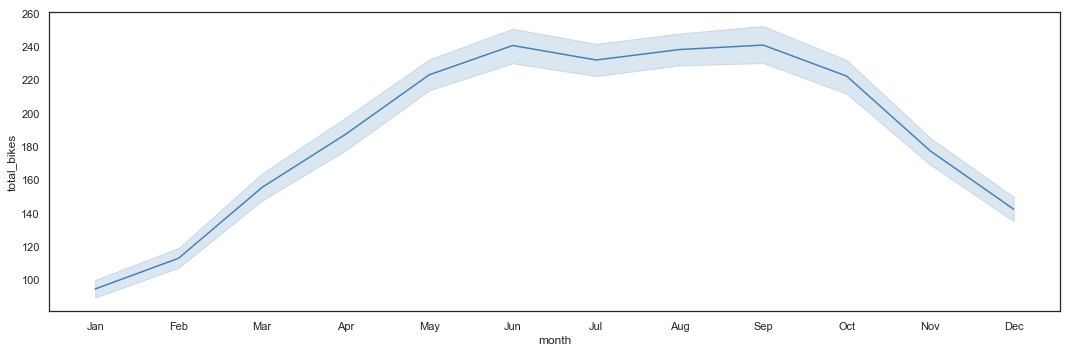

In [19]:
# Total_bikes by Month - Line Plot
plt.figure(figsize=(15,5))
g = sns.lineplot(x = hours_df.month,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.tight_layout()

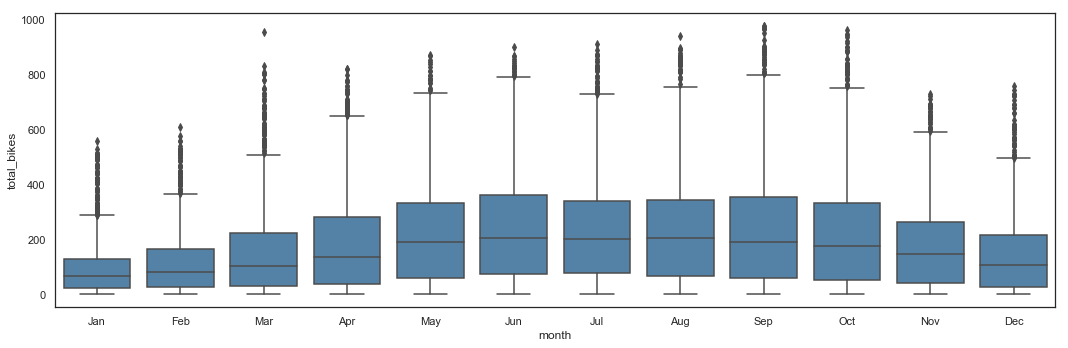

In [20]:
# Total_bikes by Month - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.month,
            y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

The average utilization per month seems to increase between April and October, with a higher variance too.

#### Bike sharing utilization by Hour

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


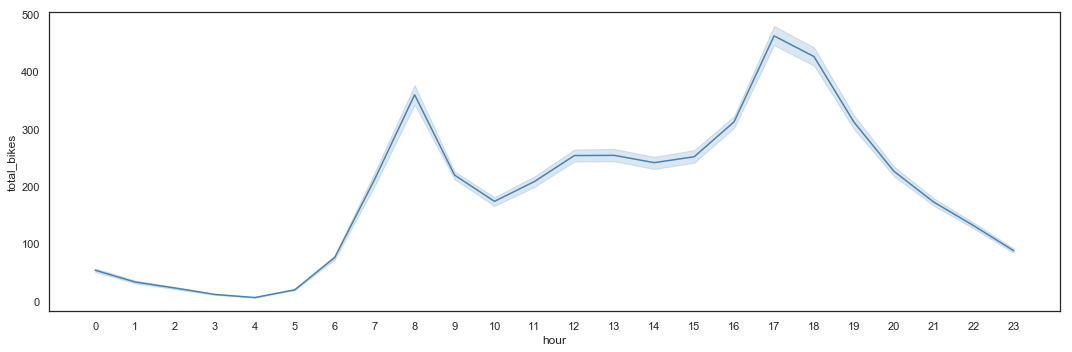

In [21]:
# Total_bikes by Hour - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.hour,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.tight_layout()

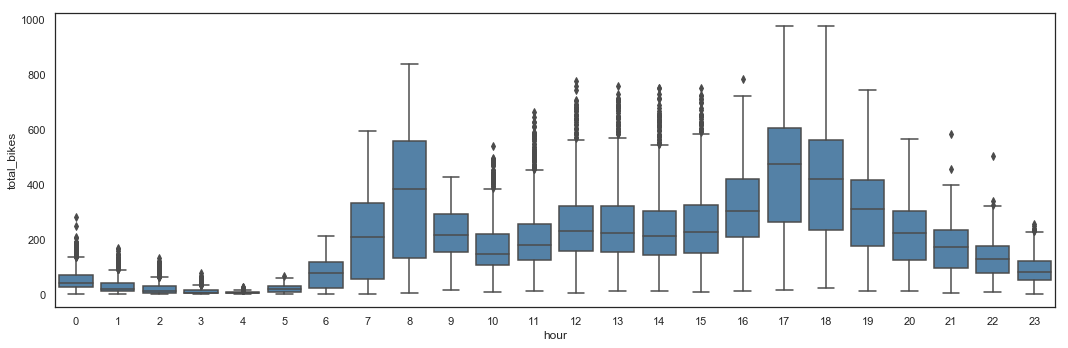

In [22]:
# Total_bikes by Hour - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.hour,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


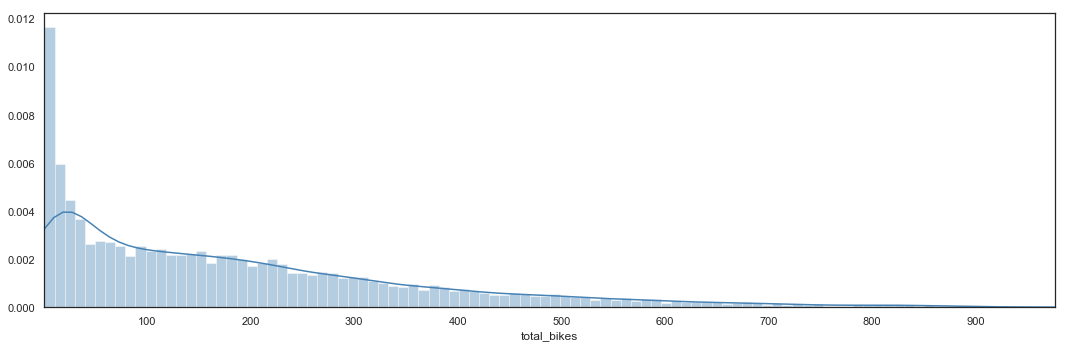

In [23]:
# Total_bikes by Hour - Distribution
plt.figure(figsize=(15,5))
sns.distplot(hours_df.total_bikes,
             bins = 100,
             color = 'steelblue').axes.set(xlim = (min(hours_df.total_bikes),max(hours_df.total_bikes)),
                                           xticks = [0,100,200,300,400,500,600,700,800,900,1000])
plt.tight_layout()

The utilization seems really similar over the day, with 2 peaks around 8am and between 5pm and 6pm. The box plot shows potential outliers in the data, which will be removed after the Feature Construction stage. It also highlight an important variance during day time, especially at peak times. The distribution plot shows that utilization is most of the time below 40 bikes simultaneously, and can reach about 1,000 bikes.

#### Bike sharing utilization by Season

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


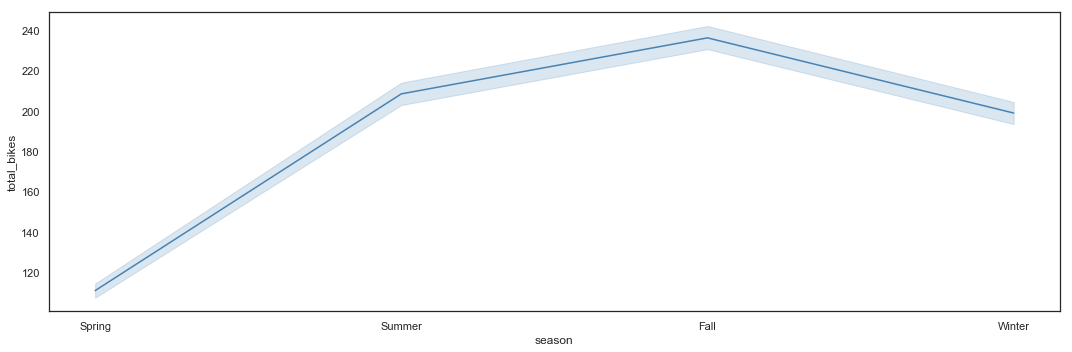

In [24]:
# Total_bikes by Season - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.season,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
plt.xticks([1,2,3,4])
plt.tight_layout()

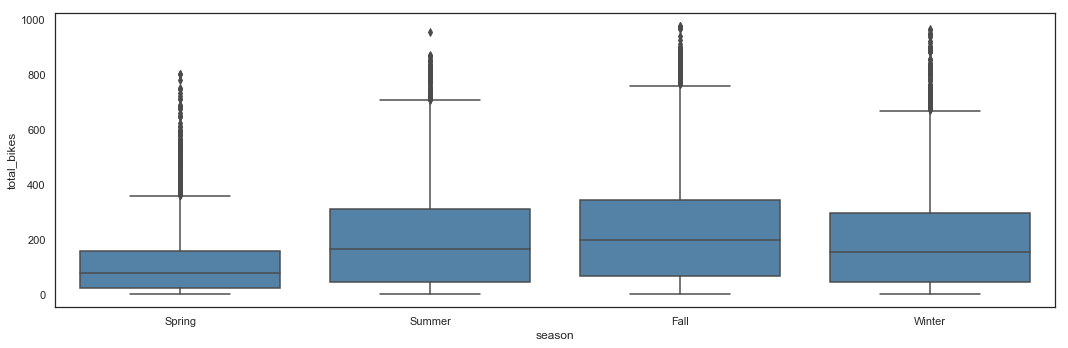

In [25]:
# Total_bikes by Season - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.season,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
plt.tight_layout()

Fall appears to be the high season, with Summer and Winter having similar utilization shapes. Spring appears to be the low season with, however, potential utilization peaks which can reach the same number of bikes than in high season.

#### Bike sharing utilization by Holiday

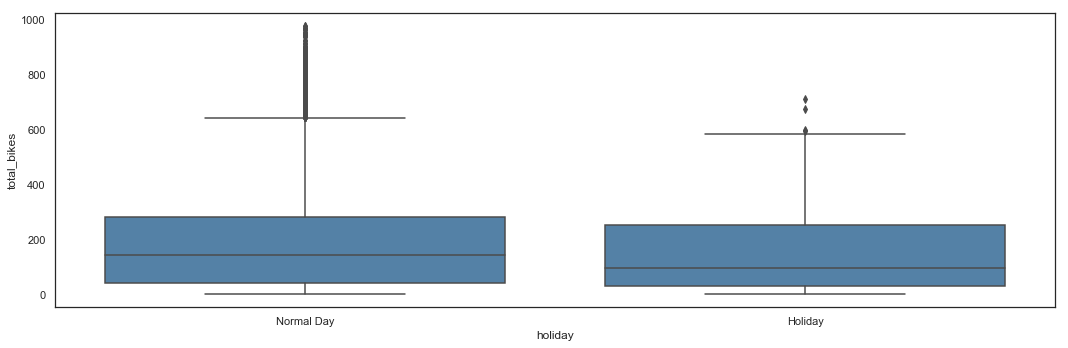

In [26]:
# Total_bikes by Holidays - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.holiday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Normal Day', 'Holiday'])
plt.tight_layout()

Utilization of bikes during holidays seems lower and with less peaks.

#### Bike sharing utilization by Weekday

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


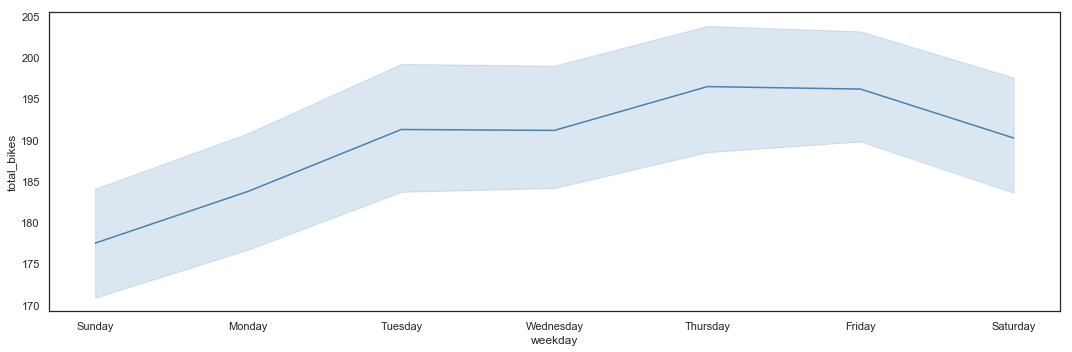

In [27]:
# Total_bikes by Weekday - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.weekday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.xticks([0,1,2,3,4,5,6])
plt.tight_layout()

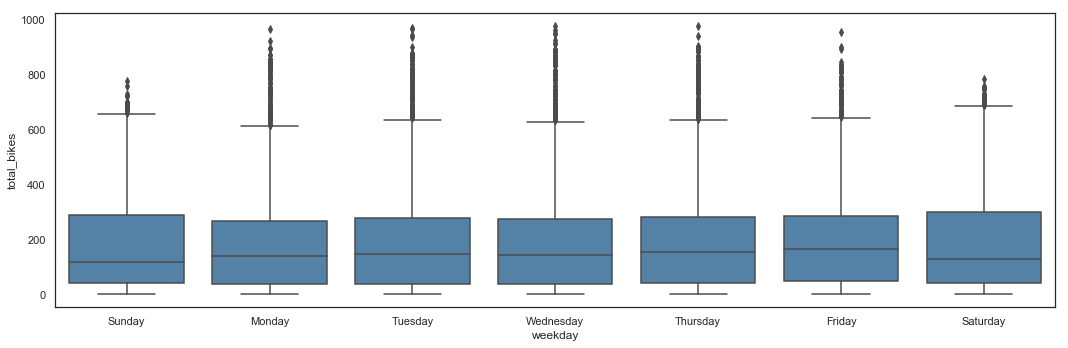

In [28]:
# Total_bikes by Weekday - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.weekday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.tight_layout()

The average utilization per hour seems higher at the end of the week, but overall, weekends appear to have lower frequentation and weekdays have higher peaks.

#### Bike sharing utilization by Working Day

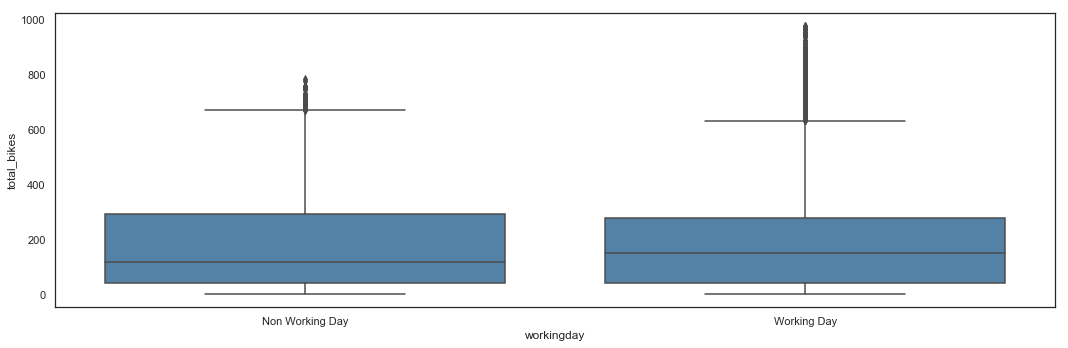

In [29]:
# Total_bikes by Working Day - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.workingday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Non Working Day', 'Working Day'])
plt.tight_layout()

Utilization seems higher during working days, with higher peaks.

#### Bike sharing utilization by Weather Condition

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


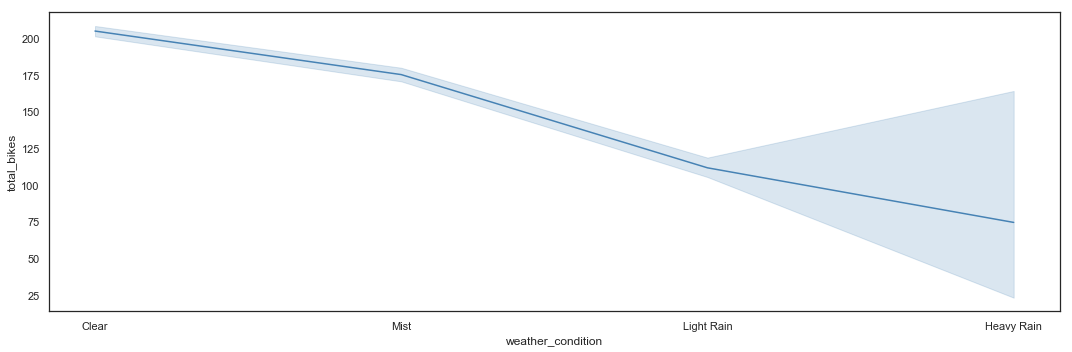

In [30]:
# Total_bikes by Weather Condition - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.weather_condition,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.xticks([1,2,3,4])
plt.tight_layout()

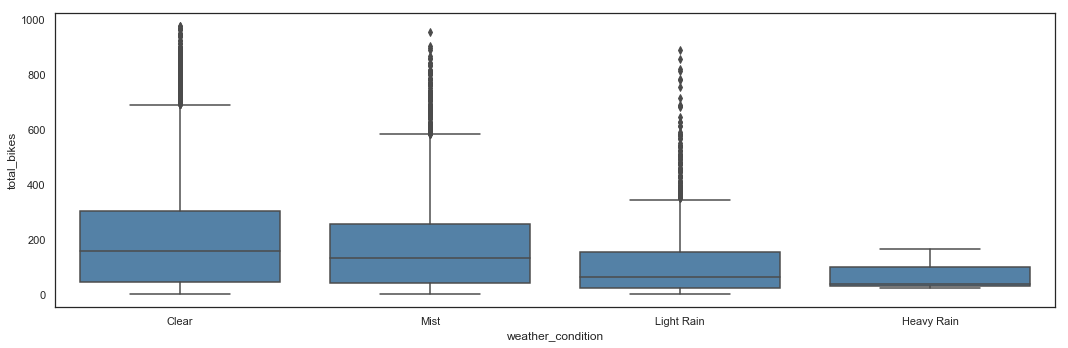

In [31]:
# Total_bikes by Weather Condition - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.weather_condition,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.tight_layout()

Unsurprisingly, bike sharing utilization is getting worse with bad weather.

#### Bike sharing utilization by Actual Temperature

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


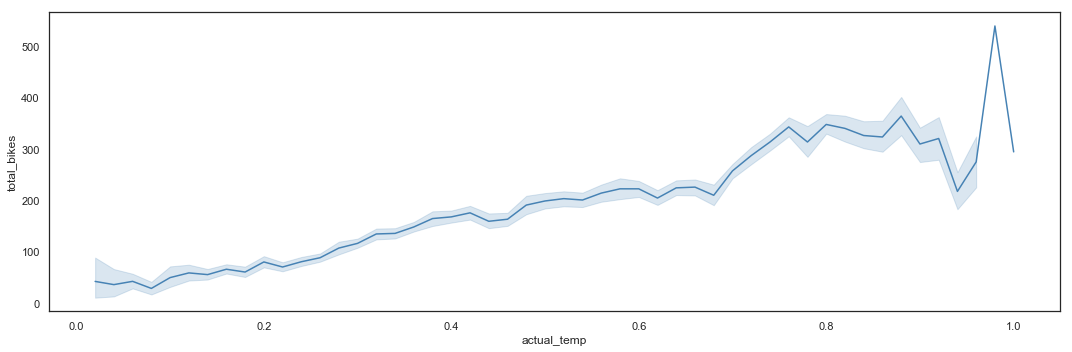

In [32]:
# Total_bikes by Actual Temperature - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.actual_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

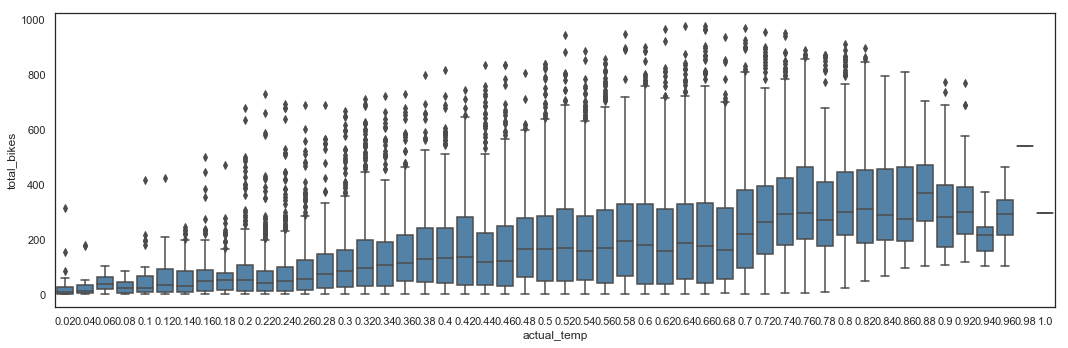

In [33]:
# Total_bikes by Actual Temperature - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.actual_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization is almost inexistant for sub-zero temperatures. It then grows with the increase of temperature, but drops down when it gets extremely hot.

#### Bike sharing utilization by Feeling Temperature

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


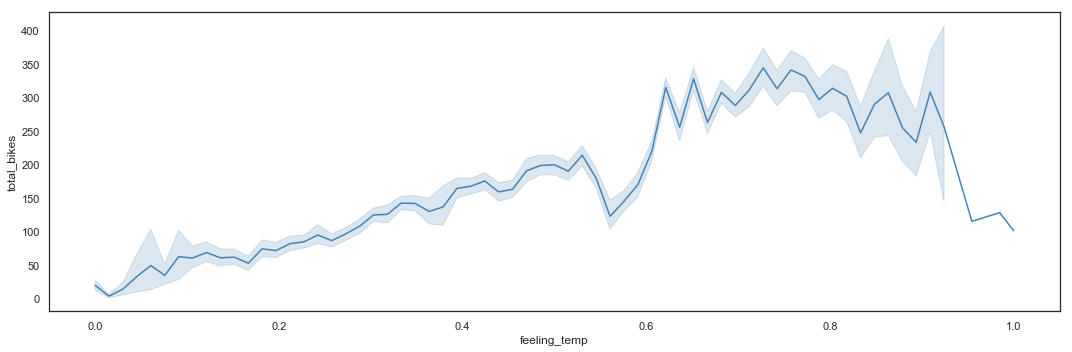

In [34]:
# Total_bikes by Feeling Temperature - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.feeling_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

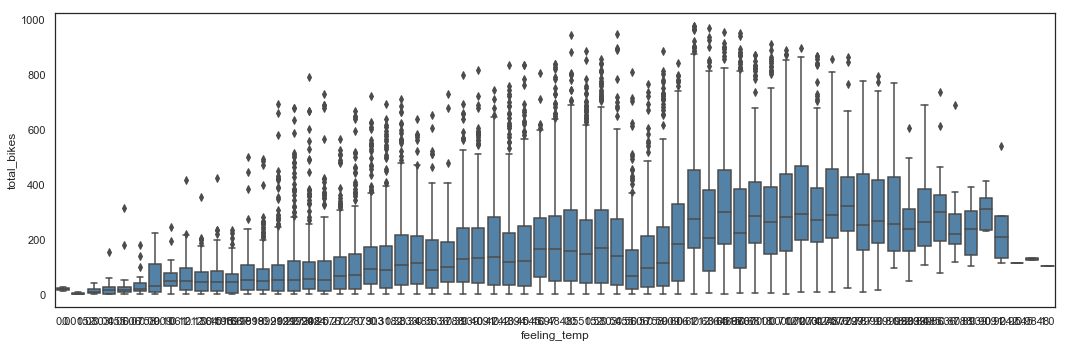

In [35]:
# Total_bikes by Feeling Temperature - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.feeling_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization by feeling temperature follows the same rules than by actual temperature.

#### Bike sharing utilization by Humidity

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


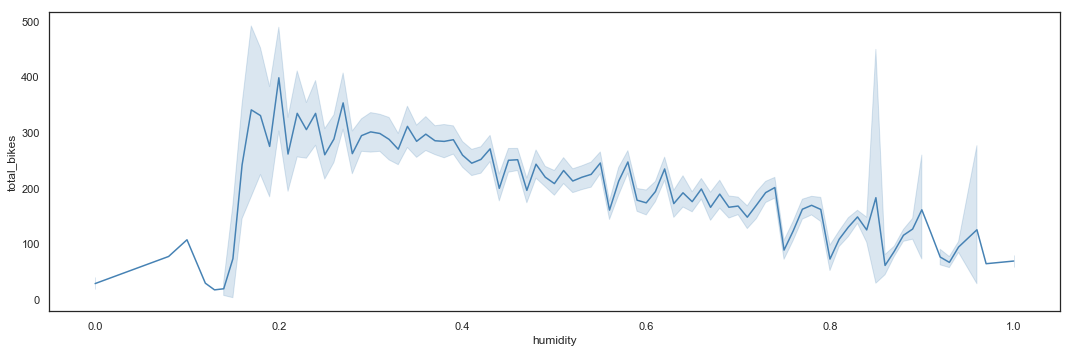

In [36]:
# Total_bikes by Humidity - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.humidity,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

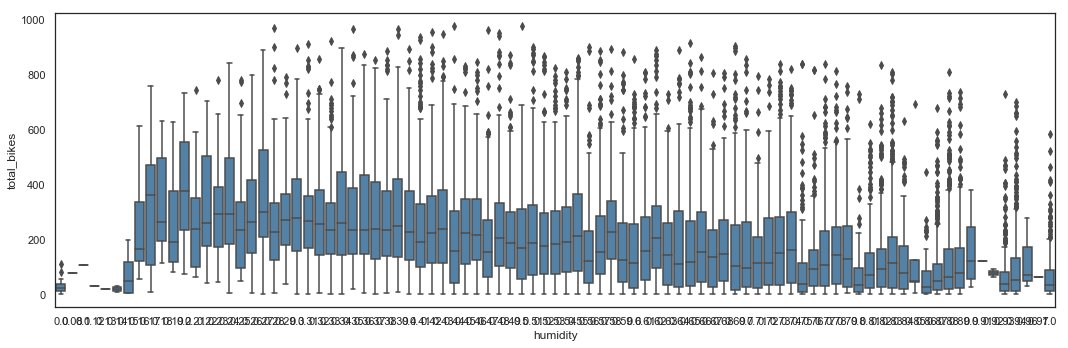

In [37]:
# Total_bikes by Humidity - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.humidity,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization of bike sharing services is decreasing with the increase of humidity.

#### Bike sharing utilization by Wind Speed

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


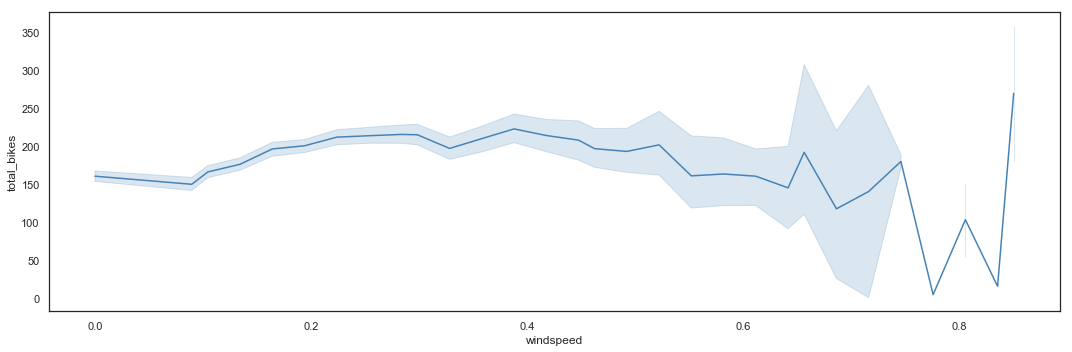

In [38]:
# Total_bikes by Wind Speed - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.windspeed,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

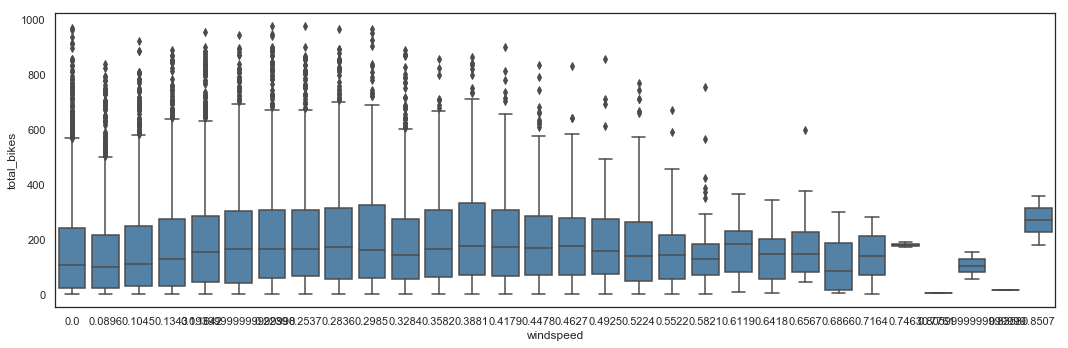

In [39]:
# Total_bikes by Wind Speed - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.windspeed,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### Bike sharing utilization by Casual

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


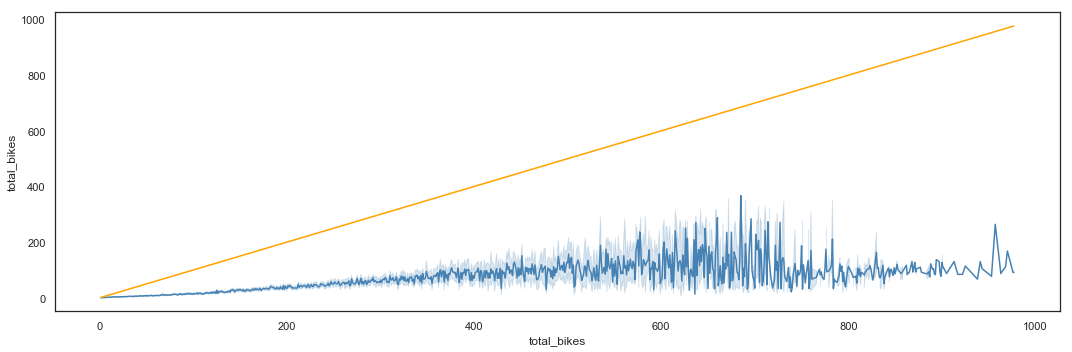

In [40]:
# Total_bikes by Casual - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = hours_df.casual,
             x = hours_df.total_bikes,
             color = 'steelblue')
sns.lineplot(y = hours_df.total_bikes,
             x = hours_df.total_bikes,
             color = 'orange')
plt.tight_layout()

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


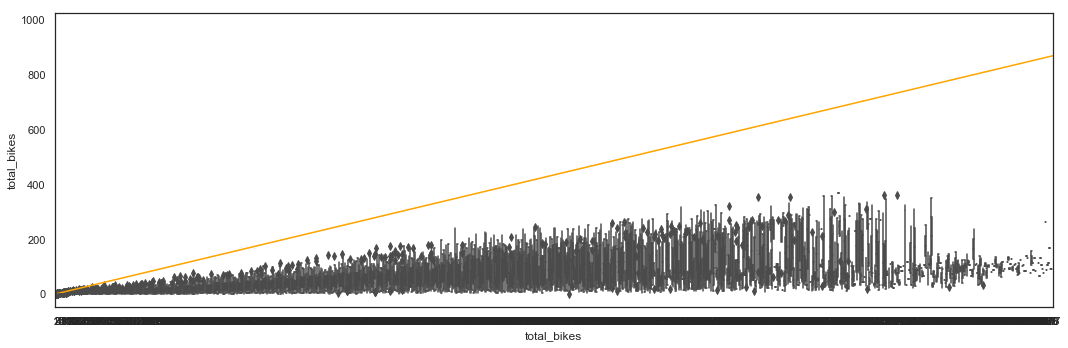

In [41]:
# Total_bikes by Casual - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = hours_df.casual,
            x = hours_df.total_bikes,
             color = 'steelblue')
sns.lineplot(y = hours_df.total_bikes,
             x = hours_df.total_bikes,
             color = 'orange')
plt.tight_layout()

<font color='red'>__COMMENTS TO UPDATE__</font>

#### Bike sharing utilization by Registered

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


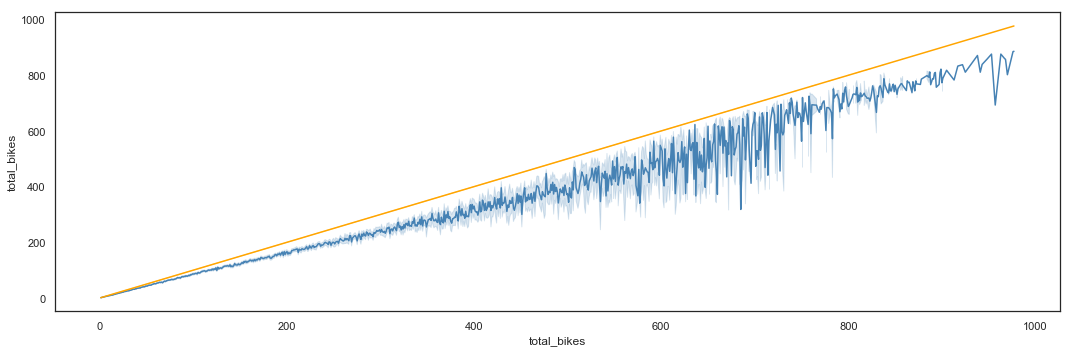

In [42]:
# Total_bikes by Registered - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = hours_df.registered,
             x = hours_df.total_bikes,
             color = 'steelblue')
sns.lineplot(y = hours_df.total_bikes,
             x = hours_df.total_bikes,
             color = 'orange')
plt.tight_layout()

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


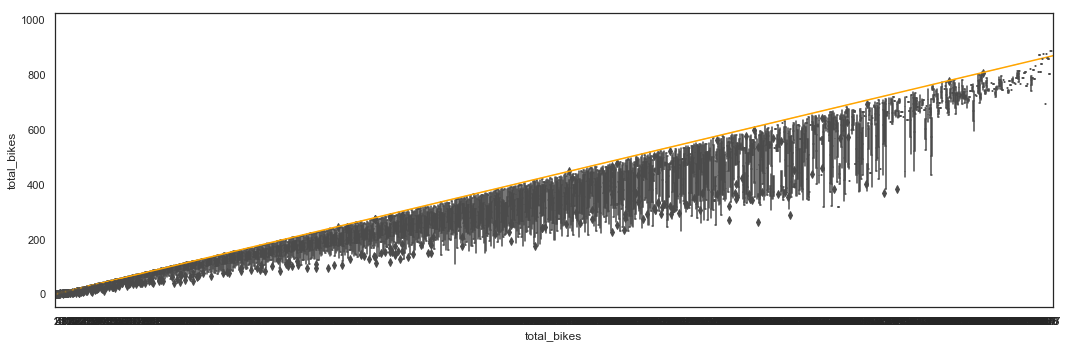

In [43]:
# Total_bikes by Registered - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = hours_df.registered,
            x = hours_df.total_bikes,
             color = 'steelblue')
sns.lineplot(y = hours_df.total_bikes,
             x = hours_df.total_bikes,
             color = 'orange')
plt.tight_layout()

<font color='red'>__COMMENTS TO UPDATE__</font>

#### Casual vs Registered Users

In [44]:
cas_reg = pd.DataFrame(hours_df.registered)
cas_reg['casual'] = hours_df.casual
cas_reg['total_bikes'] = hours_df.total_bikes
cas_reg['ratio_cas_tot'] = np.where(cas_reg.total_bikes == 0,0,round(cas_reg.casual / cas_reg.total_bikes,4))
cas_reg['diff_cas_reg'] = cas_reg.registered - cas_reg.casual

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


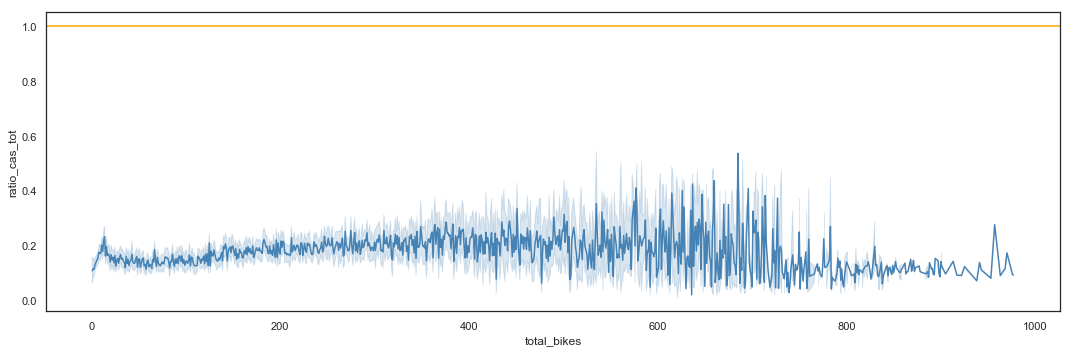

In [45]:
# Ratio of Casual Users - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = cas_reg.ratio_cas_tot,
             x = cas_reg.total_bikes,
             color = 'steelblue')
plt.axhline(1, color='orange')
plt.tight_layout()

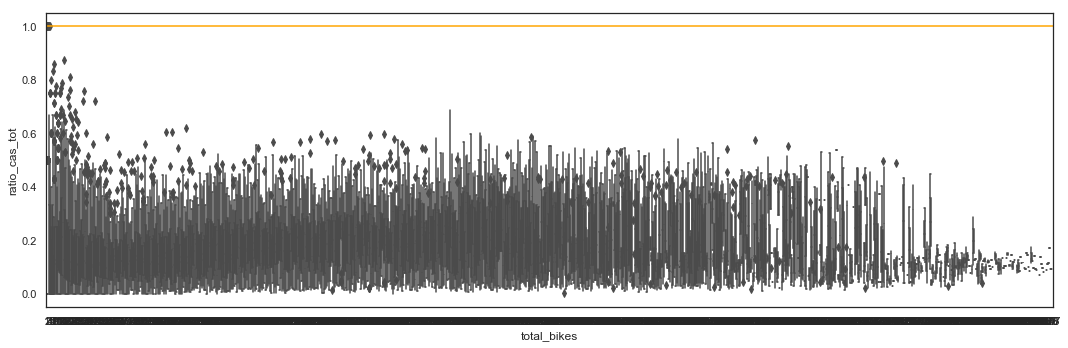

In [46]:
# Ratio of Casual Users - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = cas_reg.ratio_cas_tot,
            x = cas_reg.total_bikes,
             color = 'steelblue')
plt.axhline(1, color='orange')
plt.tight_layout()

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


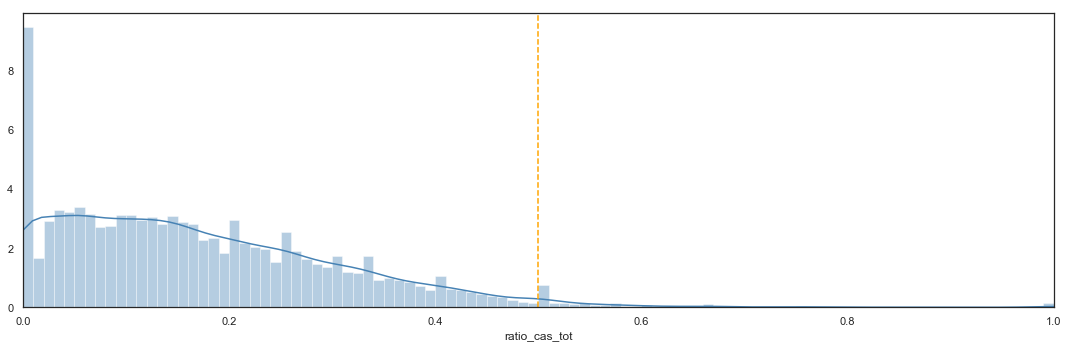

In [47]:
# Ratio of Casual Users - Distribution
plt.figure(figsize=(15,5))
sns.distplot(cas_reg.ratio_cas_tot,
             bins = 100,
             color = 'steelblue').axes.set(xlim = (min(cas_reg.ratio_cas_tot),max(cas_reg.ratio_cas_tot)))
plt.axvline(0.5, color='orange', linestyle='--')
plt.tight_layout()

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


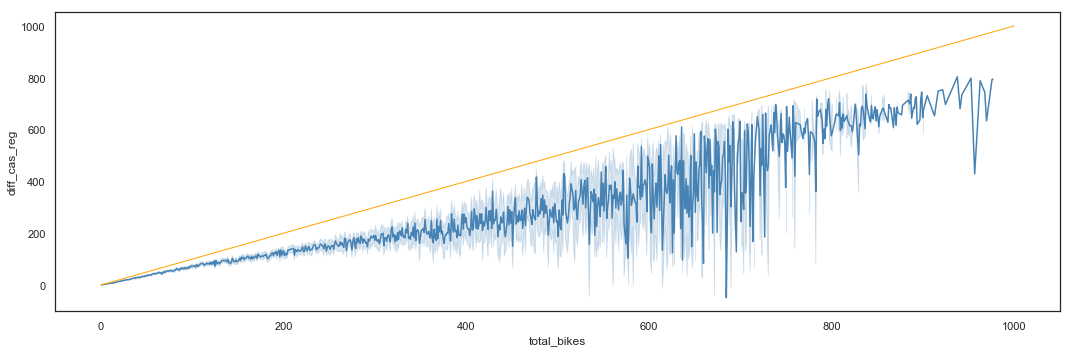

In [48]:
# Difference of Casual Users - Line Plot
x_plot = np.linspace(0, 1000, 1000)
plt.figure(figsize=(15,5))
sns.lineplot(y = cas_reg.diff_cas_reg,
             x = cas_reg.total_bikes,
             color = 'steelblue')
plt.plot(x_plot, x_plot, lw=1, linestyle = 'solid', color='orange')
plt.tight_layout()

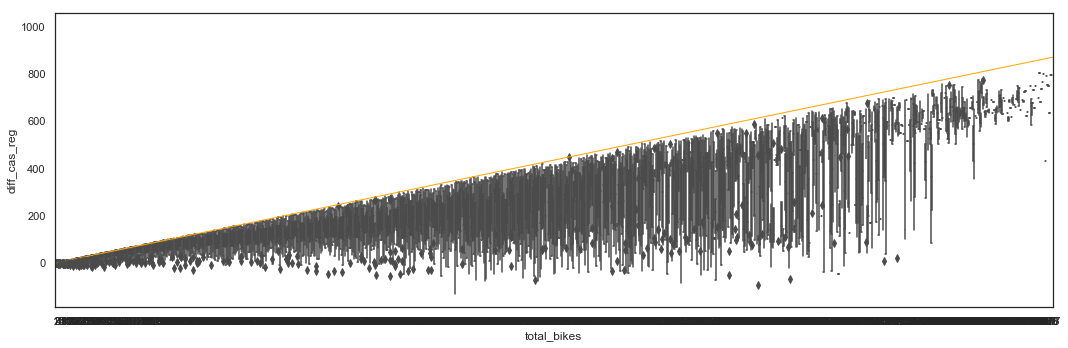

In [49]:
# Difference of Casual Users - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = cas_reg.diff_cas_reg,
            x = cas_reg.total_bikes,
             color = 'steelblue')
plt.plot(x_plot, x_plot, lw=1, linestyle = 'solid', color='orange')
plt.tight_layout()

<font color='red'>__COMMENTS TO UPDATE__</font>

#### Total_Bikes by Hour with Weekday Hue

<font color='red'>__TO DO__</font>

#### Total_Bikes by Hour with Weekday Hue for Casual Users

<font color='red'>__TO DO__</font>

#### Total_Bikes by Hour with Weather Conditions Hue

<font color='red'>__TO DO__</font>

#### Total_Bikes by Hour with Seasons Hue

<font color='red'>__TO DO__</font>

#### Pair Plot

/Users/Ashley/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x1a1ecbef60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


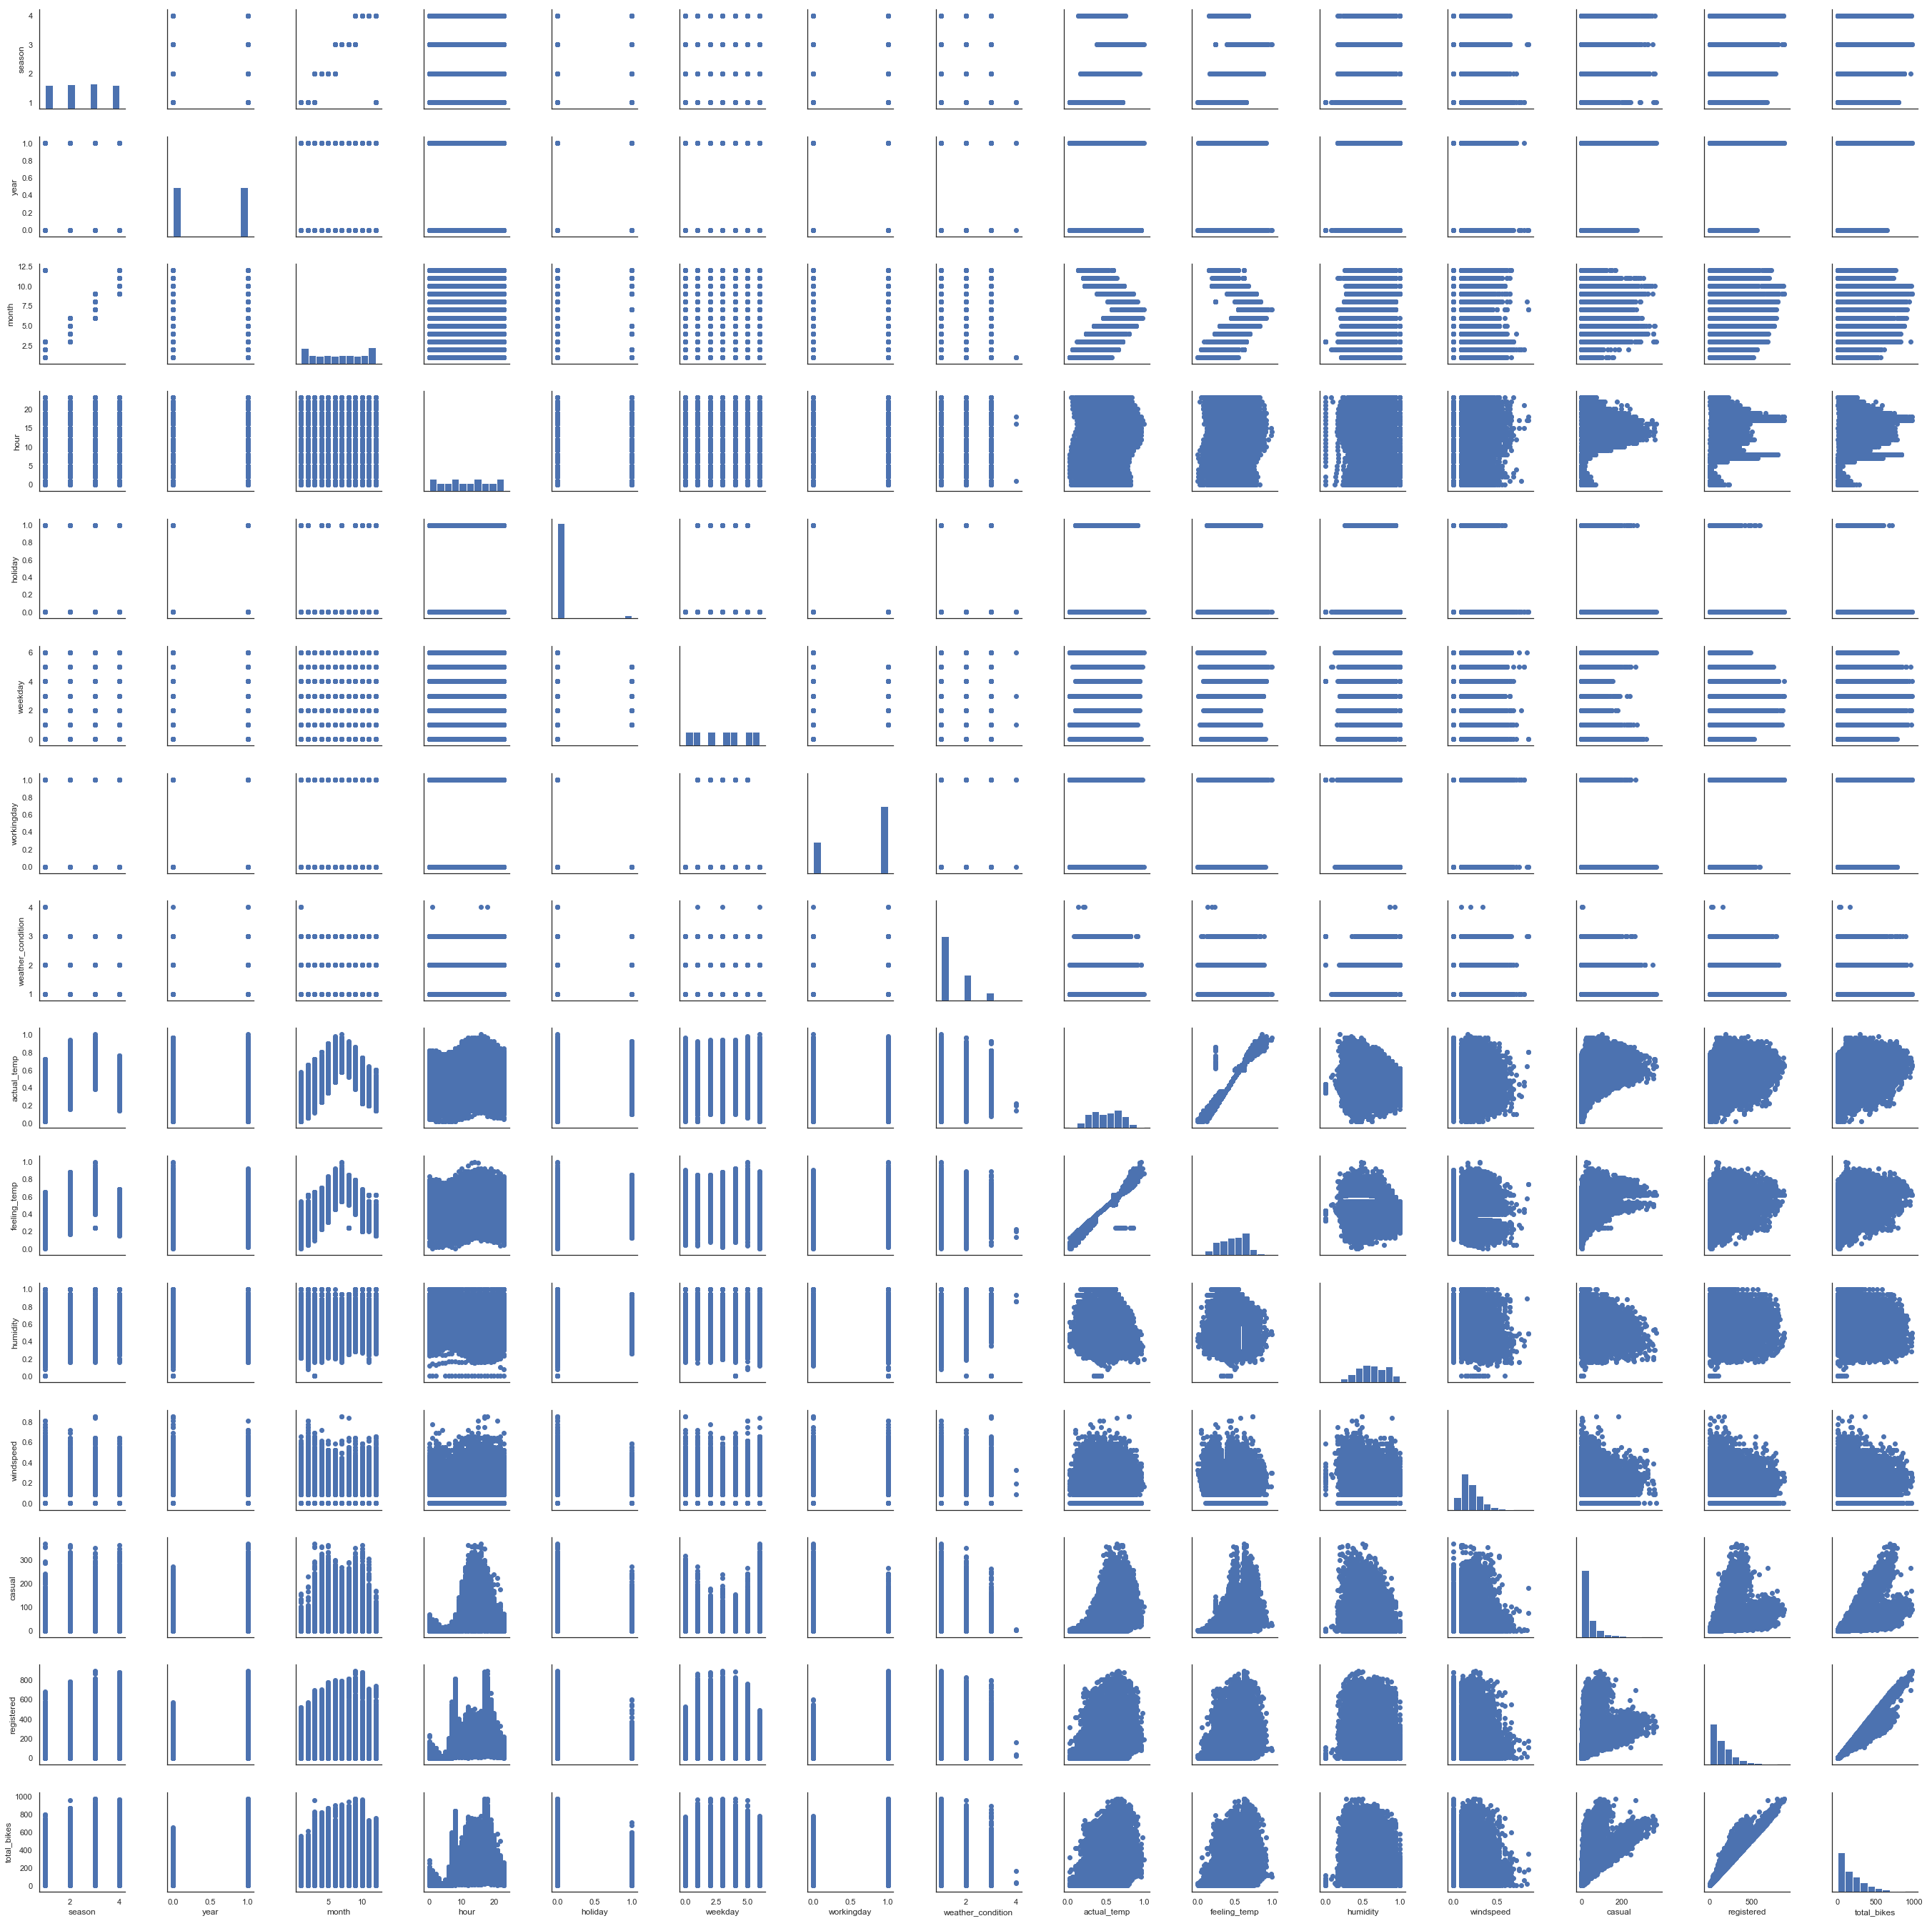

In [50]:
plot = sns.PairGrid(hours_df, palette=('steelblue', 'crimson'))
plot = plot.map_diag(plt.hist)
plot = plot.map_offdiag(plt.scatter)
plot.add_legend()
plt.tight_layout()

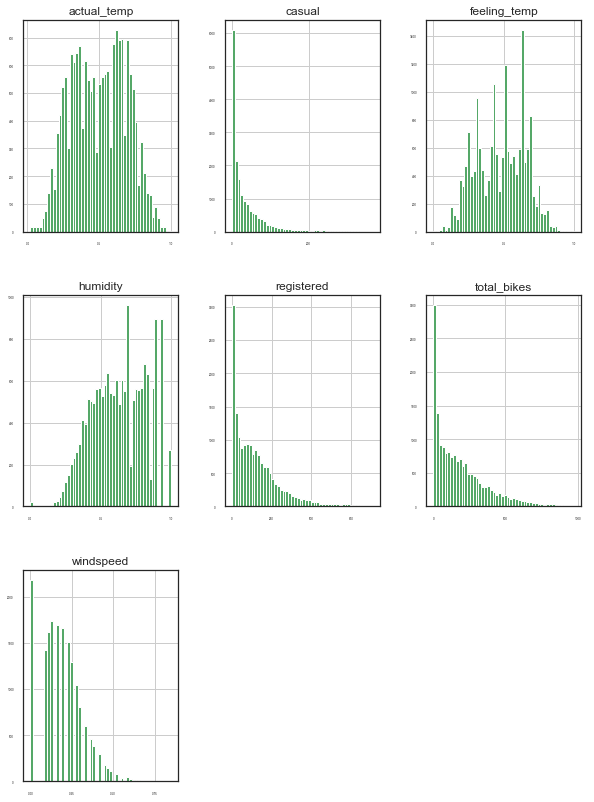

In [51]:
hours_df_num = hours_df.select_dtypes(include = ['float64', 'int64']);
hours_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color='g');

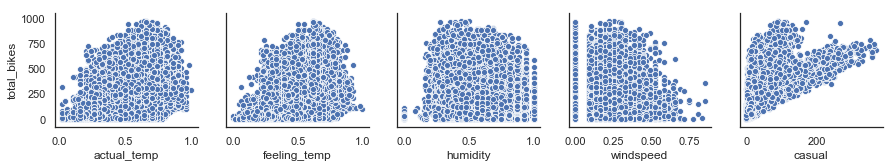

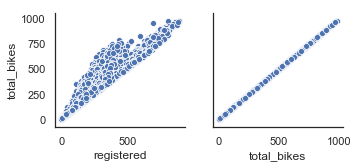

In [52]:
for i in range(0, len(hours_df_num.columns), 5):
    sns.pairplot(data=hours_df_num,
                x_vars=hours_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

<font color='red'>__TO IMPROVE__</font>

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

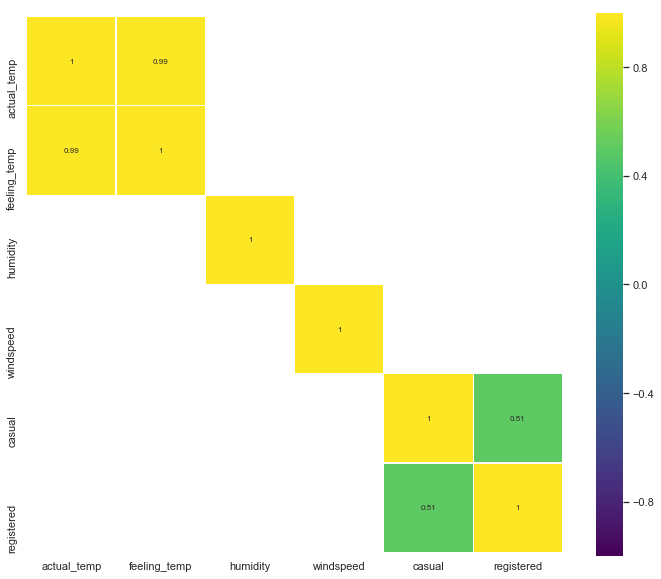

In [53]:
corr_1 = hours_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_1[(corr_1 >= 0.5) | (corr_1 <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [54]:
hours_num_corr = hours_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list_1 = hours_num_corr[abs(hours_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list_1), golden_features_list_1))

There is 2 strongly correlated values with Total Bikes:
registered    0.972151
casual        0.694564
Name: total_bikes, dtype: float64


<font color='red'>__TO IMPROVE__</font>

### Scaling and Skewness

In [55]:
hours_prep_scaled = hours_df.copy().drop('date',axis=1)
df_desc(hours_prep_scaled)

,dtype,NAs,Numerical,Boolean,Categorical,Date
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False
feeling_temp,float64,0,True,False,False,False


In [56]:
scaler = MinMaxScaler()
print(scaler.fit(hours_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']]))
hours_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']] = pd.DataFrame(scaler.fit_transform(hours_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']]))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [57]:
days_prep_scaled = days_df.copy().drop('date',axis=1)

scaler = MinMaxScaler()
print(scaler.fit(days_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']]))
days_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']] = pd.DataFrame(scaler.fit_transform(days_prep_scaled[['actual_temp','feeling_temp','humidity','windspeed','casual','total_bikes']]))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [58]:
hours_prep_scaled.head()

,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,0,1,0,0,6,0,1,0.224490,0.2879,0.81,0.0,0.008174,13,0.015369
1,1,0,1,1,0,6,0,1,0.204082,0.2727,0.80,0.0,0.021798,32,0.039959
2,1,0,1,2,0,6,0,1,0.204082,0.2727,0.80,0.0,0.013624,27,0.031762
3,1,0,1,3,0,6,0,1,0.224490,0.2879,0.75,0.0,0.008174,10,0.012295
4,1,0,1,4,0,6,0,1,0.224490,0.2879,0.75,0.0,0.000000,1,0.000000


In [59]:
days_prep_scaled.head()

,id,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,1,0,1,0,6,0,2,0.355170,0.373517,0.828620,0.284606,0.096538,654,0.110792
1,2,1,0,1,0,0,0,2,0.379232,0.360541,0.715771,0.466215,0.037852,670,0.089623
2,3,1,0,1,0,1,1,1,0.171000,0.144830,0.449638,0.465740,0.034624,1229,0.152669
3,4,1,0,1,0,2,1,1,0.175530,0.174649,0.607131,0.284297,0.031103,1454,0.177174
4,5,1,0,1,0,3,1,1,0.209120,0.197158,0.449313,0.339143,0.023474,1518,0.181546


In [60]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

<font color='red'>__HISTOGRAM BEFORE SKEWNESS__</font>

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


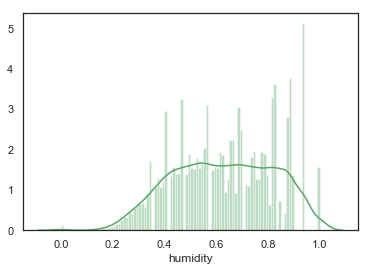

In [61]:
sns.distplot(hours_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

In [62]:
fix_skewness(hours_prep_scaled)
fix_skewness(days_prep_scaled)

,id,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,1,0,1,0,6,0,2,0.355170,0.373517,0.828620,0.217063,0.081339,654,0.110792
1,2,1,0,1,0,0,0,2,0.379232,0.360541,0.715771,0.308423,0.035306,670,0.089623
2,3,1,0,1,0,1,1,1,0.171000,0.144830,0.449638,0.308216,0.032484,1229,0.152669
3,4,1,0,1,0,2,1,1,0.175530,0.174649,0.607131,0.216884,0.029367,1454,0.177174
4,5,1,0,1,0,3,1,1,0.209120,0.197158,0.449313,0.247328,0.022473,1518,0.181546
5,6,1,0,1,0,4,1,1,0.180948,0.202329,0.532916,0.120326,0.024081,1518,0.182237
6,7,1,0,1,0,5,1,2,0.171197,0.170340,0.512798,0.226832,0.039604,1362,0.171192
7,8,1,0,1,0,6,0,2,0.131919,0.109191,0.550985,0.324382,0.018681,891,0.107800
8,9,1,0,1,0,0,0,1,0.098690,0.048706,0.446444,0.395199,0.014830,768,0.092039
9,10,1,0,1,0,1,1,1,0.114266,0.094271,0.496573,0.284815,0.011201,1280,0.149448


### Encoding Categorical Variables

In [63]:
hours_prep_scaled_encoded = hours_prep_scaled.copy()
days_prep_scaled_encoded = days_prep_scaled.copy()

In [64]:
hours_prep_scaled_encoded = hours_prep_scaled_encoded.drop(['registered'], axis=1)
days_prep_scaled_encoded = days_prep_scaled_encoded.drop(['registered'], axis=1)
df_desc(days_prep_scaled_encoded)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False
feeling_temp,float64,0,True,False,False,False


In [65]:
def date_features(df):
    columns = df.columns
    return df.select_dtypes(include=[np.datetime64]).columns

def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    date_columns = date_features(df)
    return(list(set(df.columns) - set(numerical_columns) - set(date_columns) ))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [66]:
hours_clean = onehot_encode(hours_prep_scaled_encoded)
dayss_clean = onehot_encode(days_prep_scaled_encoded)
df_desc(hours_clean)

,dtype,NAs,Numerical,Boolean,Categorical,Date
actual_temp,float64,0,True,False,False,False
feeling_temp,float64,0,True,False,False,False
humidity,float64,0,True,False,False,False
windspeed,float64,0,True,False,False,False
casual,float64,0,True,False,False,False
total_bikes,float64,0,True,False,False,False
holiday_0,uint8,0,False,True,False,False
holiday_1,uint8,0,False,True,False,False
weekday_0,uint8,0,False,True,False,False
weekday_1,uint8,0,False,True,False,False


In [67]:
# Rename columns
hours_clean.rename(columns={'year_0':'year_2011',
                        'year_1':'year_2012',
                        'holiday_0':'holiday_no',
                        'holiday_1':'holiday_yes',
                        'season_1':'season_spring',
                        'season_2':'season_summer',
                        'season_3':'season_fall',
                        'season_4':'season_winter',
                        'workingday_0':'workingday_no',
                        'workingday_1':'workingday_yes',
                        'month_1':'month_jan',
                        'month_2':'month_feb',
                        'month_3':'month_mar',
                        'month_4':'month_apr',
                        'month_5':'month_may',
                        'month_6':'month_jun',
                        'month_7':'month_jul',
                        'month_8':'month_aug',
                        'month_9':'month_sep',
                        'month_10':'month_oct',
                        'month_11':'month_nov',
                        'month_12':'month_dec',
                        'weather_condition_1':'weather_condition_clear',
                        'weather_condition_2':'weather_condition_mist',
                        'weather_condition_3':'weather_condition_light_rain',
                        'weather_condition_4':'weather_condition_heavy_rain',
                        'weekday_0':'weekday_sunday',
                        'weekday_1':'weekday_monday',
                        'weekday_2':'weekday_tuesday',
                        'weekday_3':'weekday_wednesday',
                        'weekday_4':'weekday_thursday',
                        'weekday_5':'weekday_friday',
                        'weekday_6':'weekday_saturday'},
                inplace=True)

In [68]:
hours_clean.head()

actual_temp  feeling_temp  humidity  windspeed    casual  total_bikes  \
0     0.224490        0.2879      0.81        0.0  0.007824     0.014911   
1     0.204082        0.2727      0.80        0.0  0.019431     0.036985   
2     0.204082        0.2727      0.80        0.0  0.012670     0.029859   
3     0.224490        0.2879      0.75        0.0  0.007824     0.012001   
4     0.224490        0.2879      0.75        0.0  0.000000     0.000000   

   holiday_no  holiday_yes  weekday_sunday  weekday_monday  weekday_tuesday  \
0           1            0               0               0                0   
1           1            0               0               0                0   
2           1            0               0               0                0   
3           1            0               0               0                0   
4           1            0               0               0                0   

   weekday_wednesday  weekday_thursday  weekday_friday  weekday_saturday  \
0                  0                 0               0                 1   
1                  0                 0               0                 1   
2                  0                 0               0                 1   
3                  0                 0               0                 1   
4                  0                 0               0                 1   

   workingday_no  workingday_yes  season_spring  season_summer  season_fall  \
0              1               0              1              0            0   
1              1               0              1              0            0   
2              1               0              1              0            0   
3              1               0              1              0            0   
4              1               0              1              0            0   

   season_winter  month_jan  month_feb  month_mar  month_apr  month_may  \
0              0          1          0          0          0          0   
1              0          1          0          0          0          0   
2              0          1          0          0          0          0   
3              0          1          0          0          0          0   
4              0          1          0          0          0          0   

   month_jun  month_jul  month_aug  month_sep  month_oct  month_nov  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   month_dec  year_2011  year_2012  hour_0  hour_1  hour_2  hour_3  hour_4  \
0          0          1          0       1       0       0       0       0   
1          0          1          0       0       1       0       0       0   
2          0          1          0       0       0       1       0       0   
3          0          1          0       0       0       0       1       0   
4          0          1          0       0       0       0       0       1   

   hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0       0       0       0       0       0        0        0        0        0   
1       0       0       0       0       0        0        0        0        0   
2       0       0       0       0       0        0        0        0        0   
3       0       0       0       0       0        0        0        0        0   
4       0       0       0       0       0        0        0        0        0   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0 

### Training/Test Split

In [69]:
def list_features(df, target):
    features = list(df)
    features.remove(target)
    return features

In [70]:
target = 'total_bikes'
features = list_features(hours_clean, target)

In [71]:
X = hours_clean[features]
X_train = X.loc[(X['year_2011']==1) | ((X['year_2012']==1) & (X['month_sep']==0) & (X['month_oct']==0) & (X['month_nov']==0) & (X['month_dec']==0)),features]
X_test = X.loc[(X['year_2012']==1) & ((X['month_sep']==1) | (X['month_oct']==1) | (X['month_nov']==1) | (X['month_dec']==1)),features]
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('X_train:', X_train.shape[0],'rows |', X_train.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('X_test:', X_test.shape[0],'rows |', X_test.shape[1], 'columns'))

X_train:   14491 rows |  62 columns
X_test:     2888 rows |  62 columns


In [72]:
X_train.groupby(['year_2011','year_2012','month_jan','month_feb','month_mar','month_apr','month_may','month_jun','month_jul','month_aug','month_sep','month_oct','month_nov','month_dec']).size().reset_index()

,year_2011,year_2012,month_jan,month_feb,month_mar,month_apr,month_may,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,0
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,744
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,744
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,720
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,744
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,718
5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,743
6,0,1,0,1,0,0,0,0,0,0,0,0,0,0,692
7,0,1,1,0,0,0,0,0,0,0,0,0,0,0,741
8,1,0,0,0,0,0,0,0,0,0,0,0,0,1,741
9,1,0,0,0,0,0,0,0,0,0,0,0,1,0,719


In [73]:
X_test.groupby(['year_2011','year_2012','month_jan','month_feb','month_mar','month_apr','month_may','month_jun','month_jul','month_aug','month_sep','month_oct','month_nov','month_dec']).size().reset_index()

,year_2011,year_2012,month_jan,month_feb,month_mar,month_apr,month_may,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,0
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,742
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,718
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,708
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,720


In [74]:
y = hours_clean.copy()
y_train = y.loc[(y['year_2011']==1) | ((y['year_2012']==1) & (y['month_sep']==0) & (y['month_oct']==0) & (y['month_nov']==0) & (y['month_dec']==0)),:]
y_test = y.loc[(y['year_2012']==1) & ((y['month_sep']==1) | (y['month_oct']==1) | (y['month_nov']==1) | (y['month_dec']==1)),:]
y_train = pd.DataFrame(y_train[target])
y_test = pd.DataFrame(y_test[target])
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('y_train:', y_train.shape[0],'rows |', y_train.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('y_test:', y_test.shape[0],'rows |', y_test.shape[1], 'columns'))

y_train:   14491 rows |   1 columns
y_test:     2888 rows |   1 columns


In [75]:
print('{:<35} {!r:>}'.format('Same indexes for X_train and y_train:', X_train.index.values.tolist() == y_train.index.values.tolist()))
print('{:<35} {!r:>}'.format('Same indexes for X_test and y_test:', X_test.index.values.tolist() == y_test.index.values.tolist()))

Same indexes for X_train and y_train: True
Same indexes for X_test and y_test: True


In [76]:
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features:',X.shape[0], 'items | ', X.shape[1],'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Train:',X_train.shape[0], 'items | ', X_train.shape[1],'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Test:',X_test.shape[0], 'items | ',  X_test.shape[1],'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target:',y.shape[0], 'items | ', 1,'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Train:',y_train.shape[0], 'items | ', 1,'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Test:',y_test.shape[0], 'items | ', 1,'columns'))

Features:        17379 items |  62 columns
Features Train:  14491 items |  62 columns
Features Test:    2888 items |  62 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns


The Train Set is arbitrarily defined as all records until August 31st 2012, and the Test Set all records from September 1st 2012. Below function will be used to repeat the operation on future dataframes including new features.

In [81]:
def train_test_split(df, target, features):
    X = df[features]
    y = pd.DataFrame(df[target])
    X_train = X.loc[(X['year_2011']==1) | ((X['year_2012']==1) & (X['month_sep']==0) & (X['month_oct']==0) & (X['month_nov']==0) & (X['month_dec']==0)),features]
    X_test = X.loc[(X['year_2012']==1) & ((X['month_sep']==1) | (X['month_oct']==1) | (X['month_nov']==1) | (X['month_dec']==1)),features]
    y_train = y.iloc[X_train.index.values.tolist()]
    y_test = y.iloc[X_test.index.values.tolist()]
    
    print('{:<35} {!r:>}'.format('Same indexes for X_train and y_train:', X_train.index.values.tolist() == y_train.index.values.tolist()))
    print('{:<35} {!r:>}'.format('Same indexes for X_test and y_test:', X_test.index.values.tolist() == y_test.index.values.tolist()))
    print()
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features:',X.shape[0], 'items | ', X.shape[1],'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Train:',X_train.shape[0], 'items | ', X_train.shape[1],'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Test:',X_test.shape[0], 'items | ',  X_test.shape[1],'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target:',y.shape[0], 'items | ', 1,'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Train:',y_train.shape[0], 'items | ', 1,'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Test:',y_test.shape[0], 'items | ', 1,'columns'))
    
    return X, X_train, X_test, y, y_train, y_test

## Baseline

In [77]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))

Intercept: [1.19718324e+12]
Coefficients: [[-7.52569089e-03 -3.88083107e-03 -1.62563370e-03  3.95389277e-03
   1.69828739e+00 -3.26939688e+11  6.34634495e+11  3.41271783e+11
  -6.20302400e+11 -6.20302400e+11 -6.20302400e+11 -6.20302400e+11
  -6.20302400e+11  3.41271783e+11 -5.79890574e+11  3.81683609e+11
  -9.82846955e+11 -9.82846955e+11 -9.82846955e+11 -9.82846955e+11
   1.81228687e+11  1.81228687e+11  1.81228687e+11  1.81228687e+11
   1.81228687e+11  1.81228687e+11  1.81228687e+11  1.81228687e+11
   1.81228687e+11  1.81228687e+11  1.81228687e+11  1.81228687e+11
   3.76343413e+11  3.76343413e+11 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 -1.08699552e+10 -1.08699552e+10
  -1.08699552e+10 -1.08699552e+10 

## Feature Engineering

### Cross Validation Strategy

### Features Construction

#### Day and Month-Day

In [78]:
# Need to be added with a JOIN

# Add the day from 'date'
# hours_df['day'] = pd.DatetimeIndex(hours_df['date']).day

# Add month-day from 'date'
# hours_df['month_day'] = pd.DatetimeIndex(hours_df['date']).strftime('%m-%d')

The variables `day` and `month_day` have been added to understand if patterns exist based on specific dates.

### Features Selection

<font color='red'>__TO UPDATE__</font>  
The dataset resulting from the Feature Engineering phase contains 58 features, with a model reaching the accuracy of 0.964. The Feature Selection phase aims to reduce the number of variables used by the model.

In [ ]:
# TEST MODEL ON ALL FE

The Recursive Feature Elimination (RFE) method is used to select the most relevant features for the model.

In [93]:
# from sklearn.exceptions import ConvergenceWarning
# import warnings
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# features_rfe = list(hours_clean)
# features_rfe.remove(target)

# X_rfe = hours_clean.loc[:, features_rfe]
# y_rfe = hours_clean.loc[:, target]

# linreg = LinearRegression()
# rfe = RFE(linreg)
# rfe = rfe.fit(X_rfe, y_rfe)

# print(sum(rfe.support_),'selected features:')
# for i in list(X_rfe.loc[:, rfe.support_]):
#    print(i)

31 selected features:
month_jun
month_aug
month_sep
hour_0
hour_1
hour_2
hour_3
hour_4
hour_5
hour_6
hour_7
hour_8
hour_9
hour_10
hour_11
hour_12
hour_13
hour_14
hour_15
hour_16
hour_17
hour_18
hour_19
hour_20
hour_21
hour_22
hour_23
weather_condition_clear
weather_condition_mist
weather_condition_light_rain
weather_condition_heavy_rain


### Outliers

In [79]:
#def remove_outliers(df):
#    x = df.drop(['total_bikes','date'], axis=1)
#    y = df.total_bikes.reset_index(drop=True)
#    ols = sm.OLS(endog = y.astype(float), exog = x.astype(float))
#    fit = ols.fit()
#    test = fit.outlier_test()['bonf(p)']
#    outliers = list(test[test<1e-3].index) 
#    df.drop(df.index[outliers])
#    return df

In [80]:
# remove_outliers(hours_prep)

### Cross Validation Strategy

In [86]:
# Time series Cross Validation

In [136]:
def performLinearRegression(X_train, y_train, X_test, y_test, algorithm):
    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    return(r2_score(y_test, y_pred))

def performTimeSeriesCV(X_train, y_train, number_folds, algorithm, parameters):
    """
    Given X_train and y_train (the test set is excluded from the Cross Validation),
    number of folds, the ML algorithm to implement and the parameters to test,
    the function acts based on the following logic: it splits X_train and y_train in a
    number of folds equal to number_folds. Then train on one fold and tests accuracy
    on the consecutive as follows:
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    Returns mean of test accuracies.
    """
 
    print ('Parameters --------------------------------> ', parameters)
    print ('Size train set: ', X_train.shape)
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print ('Size of each fold: ', k)
    
    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    r2_metric = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print ('')
        
        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out 
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second), 
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds 
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i
        
        # example with i = 4 (first 4 folds):
        #      Splitting the first       4        chunks at          3      /        4
        print ('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )
        
        # as we loop over the folds X and y are updated and increase in size.
        # This is the data that is going to be split and it increases in size 
        # in the loop as we account for more folds. If k = 300, with i starting from 2
        # the result is the following in the loop
        # i = 2
        # X = X_train[:(600)]
        # y = y_train[:(600)]
        #
        # i = 3
        # X = X_train[:(900)]
        # y = y_train[:(900)]
        # .... 
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print ('Size of train + test: ', X.shape) # the size of the dataframe is going to be k*i
 
        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # i starts from 2 so the zeroth element in accuracies array is i-2. performClassification() is a function which takes care of a classification problem. This is only an example and you can replace this function with whatever ML approach you need.
        r2_metric[i-2] = performLinearRegression(X_trainFolds, y_trainFolds, X_testFold, y_testFold, algorithm)
        
        # example with i = 4:
        #      Accuracy on fold         4     :    0.85423
        print ('R2 on fold ' + str(i) + ': ', r2_metric[i-2])
    
    # the function returns the mean of the accuracy on the n-1 folds    
    
    r2_metric = r2_metric[r2_metric > 0]
    return r2_metric.mean()

In [137]:
performTimeSeriesCV(X_train, y_train, 20, 'lm', [])

Parameters -------------------------------->  []
Size train set:  (16552, 62)
Size of each fold:  827

Splitting the first 2 chunks at 1/2
Size of train + test:  (1654, 62)
R2 on fold 2:  -6.320675437693588e+20

Splitting the first 3 chunks at 2/3
Size of train + test:  (2481, 62)
R2 on fold 3:  -9.866760926369068e+24

Splitting the first 4 chunks at 3/4
Size of train + test:  (3308, 62)
R2 on fold 4:  -2.0398615870076776e+24

Splitting the first 5 chunks at 4/5
Size of train + test:  (4135, 62)
R2 on fold 5:  -2.284267523634934e+22

Splitting the first 6 chunks at 5/6
Size of train + test:  (4962, 62)
R2 on fold 6:  -2.603240750694199e+23

Splitting the first 7 chunks at 6/7
Size of train + test:  (5789, 62)
R2 on fold 7:  -1.5659867189127e+23

Splitting the first 8 chunks at 7/8
Size of train + test:  (6616, 62)
R2 on fold 8:  -1.8257904288801566e+25

Splitting the first 9 chunks at 8/9
Size of train + test:  (7443, 62)
R2 on fold 9:  -2.1404479994427015e+21

Splitting the first 10 c

0.7349328840392864

In [116]:
tscv = TimeSeriesSplit(n_splits=20)
print(tscv)  

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))



TimeSeriesSplit(max_train_size=None, n_splits=20)
Variance score (R2): -3435847412835151824027648.00
Variance score (R2): -61992128881602365772267520.00
Variance score (R2): -2097307217506276420354048.00
Variance score (R2): -73384880602950852608.00
Variance score (R2): -2842452146612647522992128.00
Variance score (R2): -50324276089168364306432.00
Variance score (R2): -15665677811101682630656.00
Variance score (R2): -33847618639940763648.00
Variance score (R2): -233143621198907146240.00
Variance score (R2): -2047608612217528516608.00
Variance score (R2): 0.74
Variance score (R2): 0.73
Variance score (R2): 0.74
Variance score (R2): 0.73
Variance score (R2): 0.76
Variance score (R2): 0.70
Variance score (R2): 0.73
Variance score (R2): 0.76
Variance score (R2): 0.73
Variance score (R2): 0.76


### Features Selection

## Final Metric

***

*Vratul Kapur | Irune Maury Arrue | Paul Jacques-Mignault | Sheena Miles | Ashley O’Mahony | Stavros Tsentemeidis | Karl Westphal  
O17 (Group G) | Master in Big Data and Business Analytics | Oct 2018 Intake | IE School of Human Sciences and Technology*

***